In [12]:
import math

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import set_matplotlib_formats

import jax.numpy as jnp
from jax import lax, random
from jax.scipy.special import expit, logit

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.distributions.transforms import OrderedTransform
from numpyro.infer import ELBO, MCMC, NUTS, SVI, Predictive, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_host_device_count(4)

In [11]:
ratings_counts = jnp.array([12, 36, 7, 41])

pr_r = ratings_counts / ratings_counts.sum()
cpr_r = jnp.cumsum(pr_r, -1)
cpr_r

DeviceArray([0.125    , 0.5      , 0.5729167, 1.       ], dtype=float32)

In [13]:
lco_r = logit(cpr_r)
lco_r

DeviceArray([-1.9459101 ,  0.        ,  0.29376122,         inf], dtype=float32)

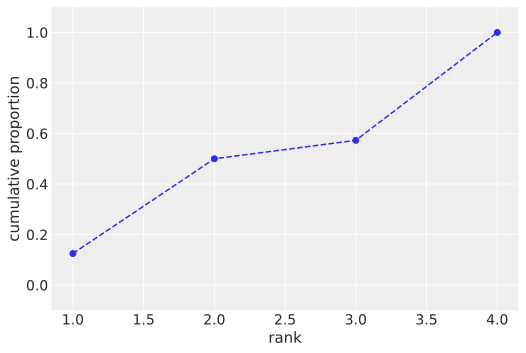

In [16]:
plt.plot(range(1, 5), cpr_r, "--o")
plt.gca().set(xlabel="rank", ylabel="cumulative proportion", ylim=(-0.1, 1.1))
plt.show()

In [19]:
hurricanes = pd.read_csv("../data/Hurricanes.csv", sep=";")
d = hurricanes
print(d.shape)
display(d.sample(3))
d.describe()

(92, 8)


,name,year,deaths,category,min_pressure,damage_norm,female,femininity
23,Betsy,1965,75,3,948,20000,1,8.33333
42,Alicia,1983,21,3,962,10400,1,9.83333
71,Lili,2002,2,1,963,1260,1,10.33333


,year,deaths,category,min_pressure,damage_norm,female,femininity
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,1982.086957,20.652174,2.086957,964.913043,7269.782609,0.673913,6.780797
std,18.770829,40.904186,1.055099,19.065331,12934.086656,0.471348,3.227222
min,1950.000000,0.000000,1.000000,909.000000,1.000000,0.000000,1.055560
25%,1964.750000,2.000000,1.000000,950.000000,245.000000,0.000000,2.666670
50%,1985.000000,5.000000,2.000000,964.000000,1650.000000,1.000000,8.500000
75%,1999.000000,20.250000,3.000000,982.250000,8162.500000,1.000000,9.388890
max,2012.000000,256.000000,5.000000,1003.000000,75000.000000,1.000000,10.444440


In [21]:
d.category.value_counts().sort_index()

1    36
2    21
3    28
4     5
5     2
Name: category, dtype: int64


## Hurricane fatalities and gender of names

### Description

Data used in Jung et al 2014 analysis of effect of gender of name on hurricane fatalities. Note that hurricanes Katrina (2005) and Audrey (1957) were removed from the data.

### Format

name : Given name of hurricane  
year : Year of hurricane  
deaths : number of deaths  
category : Severity code for storm  
min_pressure : Minimum pressure, a measure of storm strength; low is stronger  
damage_norm : Normalized estimate of damage in dollars  
female : Indicator variable for female name  
femininity : 1-11 scale from totally masculine (1) to totally feminine (11) for name. Average of 9 scores from 9 raters.  


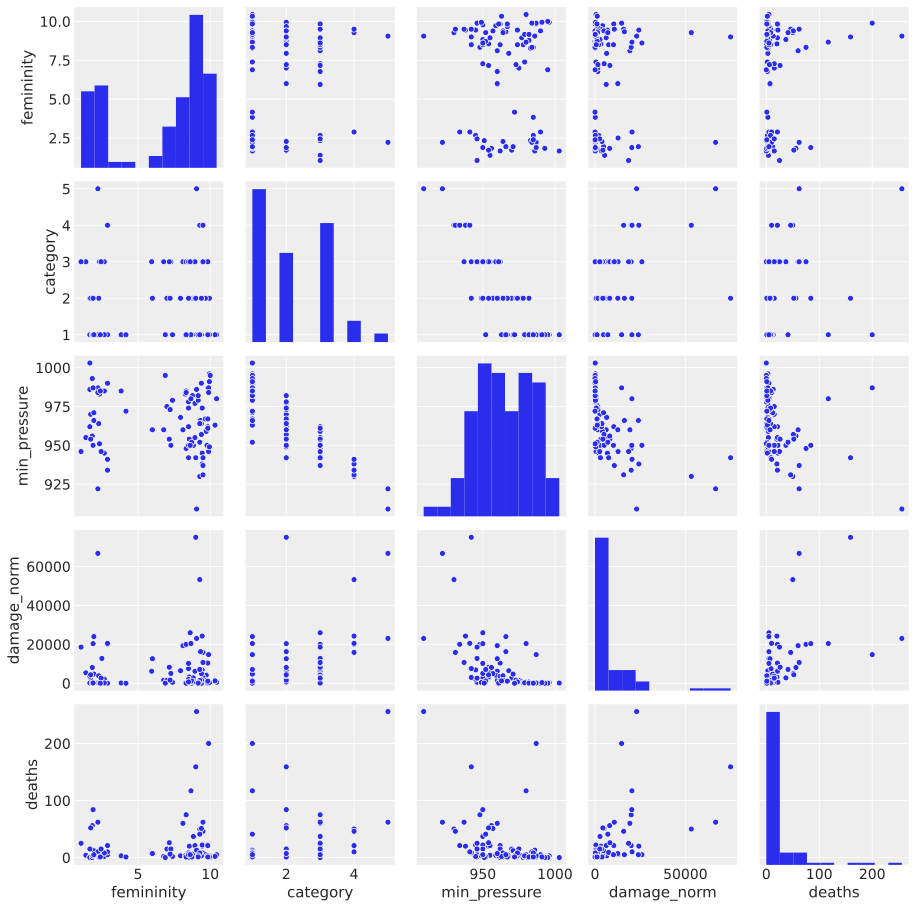

In [26]:
import seaborn as sns
sns.pairplot(d[['femininity', 'category', 'min_pressure', 'damage_norm', 'deaths']])

In [77]:
def model1(deaths=None, femininity=None):
    a = numpyro.sample("a", dist.Normal(0, .3))
    bF = numpyro.sample("bF", dist.Normal(0.2, .25))
    lambda_ = numpyro.deterministic("lambda", jnp.exp(a + bF * femininity))
    numpyro.sample("deaths", dist.Poisson(lambda_), obs=deaths)

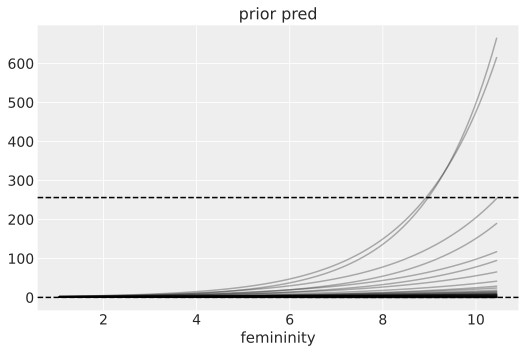

In [78]:
x = jnp.linspace(d.femininity.min(), d.femininity.max(), 100)
lmu = Predictive(model1, num_samples=100, return_sites=["lambda"]).get_samples(
    random.PRNGKey(53),
    femininity=x,
)["lambda"]
plt.axhline(y=d.deaths.min(), c="k", ls="--")
plt.axhline(y=d.deaths.max(), c="k", ls="--")#, lw=0.5)
plt.title("prior pred")
plt.xlabel('femininity')

for i in range(40):
    plt.plot(x, lmu[i], "k", alpha=0.3)

In [72]:
mcmc = MCMC(NUTS(model1), 500, 500)
mcmc.run(random.PRNGKey(0), femininity=d.femininity.values, deaths=d.deaths.values)
mcmc.print_summary()
post1 = mcmc.get_samples()

sample: 100%|██████████| 1000/1000 [00:03<00:00, 264.30it/s, 3 steps of size 2.45e-01. acc. prob=0.93]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.39      0.07      2.40      2.30      2.50    101.37      1.00
        bF      0.09      0.01      0.09      0.07      0.10    101.24      1.00

Number of divergences: 0


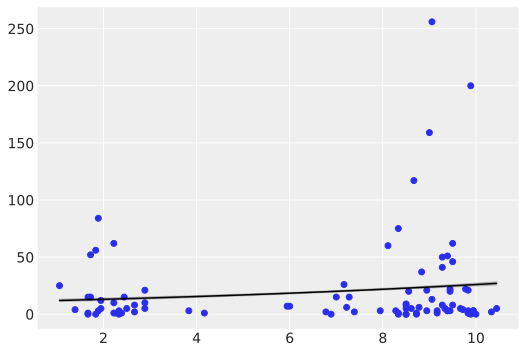

In [93]:
x = jnp.linspace(d.femininity.min(), d.femininity.max(), 100)
pred = Predictive(model1, post1, return_sites=["lambda"]).get_samples(random.PRNGKey(33), femininity=x)
lmu = jnp.mean(pred['lambda'], 0)
lci = jnp.percentile(pred['lambda'], q=(5.5, 94.5), axis=0)

plt.scatter(d.femininity.values, d.deaths.values)
plt.plot(x, lmu, 'k')
plt.fill_between(x, lci[0], lci[1], color='k', alpha=0.2)

In [95]:
def model2(deaths=None):
    a = numpyro.sample("a", dist.Normal(0, .3))
    lambda_ = numpyro.deterministic("lambda", jnp.exp(a))
    numpyro.sample("deaths", dist.Poisson(lambda_), obs=deaths)

In [98]:
mcmc = MCMC(NUTS(model2), 500, 500)
mcmc.run(random.PRNGKey(0), deaths=d.deaths.values)
mcmc.print_summary()
post2 = mcmc.get_samples()

sample: 100%|██████████| 1000/1000 [00:03<00:00, 269.73it/s, 3 steps of size 9.49e-01. acc. prob=0.92]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.01      0.02      3.01      2.97      3.04    188.69      1.01

Number of divergences: 0


In [111]:
def model3(deaths=None, femininity=None):
    a = numpyro.sample("a", dist.Normal(0, 5))
    bF = numpyro.sample("bF", dist.Normal(0.2, .25))    
    phi = numpyro.sample("phi", dist.Exponential(1))
    lambda_ = numpyro.deterministic("lambda", jnp.exp(a + bF * femininity))
    numpyro.sample("deaths", dist.GammaPoisson(lambda_ / phi, 1 / phi), obs=deaths)

In [112]:
mcmc = MCMC(NUTS(model3), 500, 500)
mcmc.run(random.PRNGKey(0), femininity=d.femininity.values, deaths=d.deaths.values)
mcmc.print_summary()
post3 = mcmc.get_samples()

sample: 100%|██████████| 1000/1000 [00:05<00:00, 195.06it/s, 3 steps of size 3.68e-01. acc. prob=0.92]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.57      0.24      2.59      2.22      3.03    146.02      1.02
        bF      0.01      0.03      0.01     -0.03      0.06    173.20      1.01
       phi     23.94      3.02     23.85     19.33     29.01    177.79      1.01

Number of divergences: 0


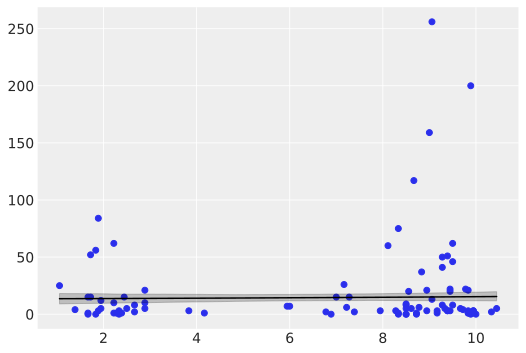

In [113]:
x = jnp.linspace(d.femininity.min(), d.femininity.max(), 100)
pred = Predictive(model3, post3, return_sites=["lambda"]).get_samples(random.PRNGKey(33), femininity=x)
lmu = jnp.mean(pred['lambda'], 0)
lci = jnp.percentile(pred['lambda'], q=(5.5, 94.5), axis=0)

plt.scatter(d.femininity.values, d.deaths.values)
plt.plot(x, lmu, 'k')
plt.fill_between(x, lci[0], lci[1], color='k', alpha=0.2)

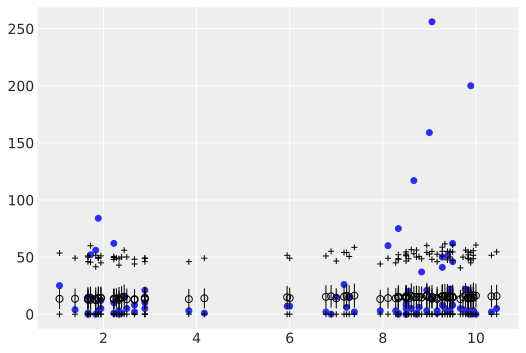

In [119]:
deaths_pred = Predictive(model3, post3)(random.PRNGKey(123), femininity=d.femininity.values)["deaths"]
plt.scatter(d.femininity.values, d.deaths.values)
plt.errorbar(
    d.femininity.values,
    jnp.mean(deaths_pred, 0),
    jnp.std(deaths_pred, 0) / 2,
    fmt="o",
    c="k",
    mfc="none",
    ms=7,
    elinewidth=1,
)
plt.plot(d.femininity.values, jnp.percentile(deaths_pred, 5.5, 0), "k+")
plt.plot(d.femininity.values, jnp.percentile(deaths_pred, 94.5, 0), "k+")